In [2]:
from google.colab import files
import torch 
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import matplotlib.image as mpimg
import math
import time
import os
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Downloading the dataset from Kaggle using API token

In [2]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
! kaggle datasets download -d 'meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'

 98% 601M/612M [00:14<00:00, 30.1MB/s]
100% 612M/612M [00:14<00:00, 44.3MB/s]


In [0]:
! mkdir data
! unzip -qq -d ./data gtsrb-german-traffic-sign.zip 

The data is splitted into two folders: test and train. 

For train data all pictures are arranged into catergories already. So an easy way to load them is to use ImageFolder class from PyTorch.

We will arrange the test data the same way, based on the classes info from the metadata file.

We will split trainset into two parts: for training and validation (80:20)

Checking the metadata for training set

In [3]:
meta_train = pd.read_csv("data/Train.csv")
meta_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
meta_train.Width.describe()

count    39209.000000
mean        50.835880
std         24.306933
min         25.000000
25%         35.000000
50%         43.000000
75%         58.000000
max        243.000000
Name: Width, dtype: float64

In [5]:
meta_train.Height.describe()

count    39209.000000
mean        50.328930
std         23.115423
min         25.000000
25%         35.000000
50%         43.000000
75%         58.000000
max        225.000000
Name: Height, dtype: float64

We will resize all images to 40x40

Splitting the test data to folders corresponding to classes

In [8]:
meta_test = pd.read_csv("data/Test.csv")
meta_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [0]:
classes = meta_test.ClassId.unique()
for cl in classes:
  os.mkdir('data/Test/'+str(cl))

In [0]:
for _, row in meta_test.iterrows():
  newdir = "data/Test/" + str(row['ClassId']) + "/" +  row['Path'].split("/")[-1]
  os.rename("data/" + row.Path, newdir )


Defining the datasets from folders

In [0]:
INPUT_DIM = 40
BATCH_SIZE = 36
transformations = transforms.Compose([
    transforms.Resize(INPUT_DIM),
    transforms.CenterCrop(INPUT_DIM),
    transforms.ToTensor()])
signs_data = datasets.ImageFolder("data/Train/", transform = transformations)
OUTPUT_DIM = len(signs_data.classes)
test_data = datasets.ImageFolder("data/Test/", transform = transformations)

Splitting the dataset into train and validation. Creating the loaders

In [0]:
val_split = 0.2
size = len(signs_data)
split = int(np.floor(val_split * size))
indices = list(range(size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(signs_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=16)
validation_loader = torch.utils.data.DataLoader(signs_data, batch_size=BATCH_SIZE, sampler=valid_sampler,  num_workers=16)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=16)



Visualisation of sample images

In [0]:
def plotImage(images, labels, classes):
  size = len(labels)
  for i in range(size):
    im_numpy = np.transpose(im[i].numpy(), (1, 2, 0))
    lab_class = classes[labels[i]]
    meta_im = mpimg.imread("data/Meta/" + lab_class + ".png")
    plt.subplot(1,2,1)
    plt.imshow(im_numpy)
    plt.subplot(1,2,2)
    plt.imshow(meta_im)
    plt.title(lab_class)
    plt.show()
  


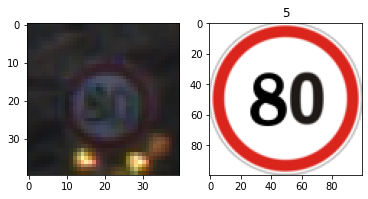

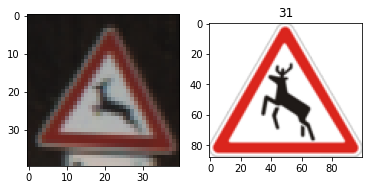

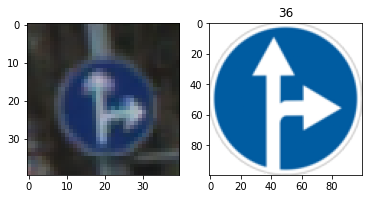

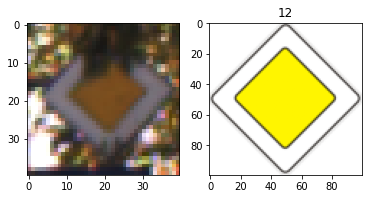

In [9]:
im, lab = next(iter(train_loader))
plotImage(im[:4], lab[:4], signs_data.classes)

Function for training a model and valiadation after each epoch

In [0]:
def trainModel(model, train_loader, val_loader, criterion, optimizer, num_epochs):
  since = time.time()
  statistics = pd.DataFrame()

  for epoch in range(num_epochs):

    # train phase
    model.train()
    running_total = 0
    running_correct = 0
    running_loss = 0.0
    i = 0

    for inputs, labels in train_loader:
      i += 1
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_total += len(labels)
      running_correct += torch.sum(preds == labels.data).item()
    
    epoch_loss = running_loss / i
    epoch_acc = running_correct / running_total

    statistics.loc[epoch, "train_loss"] = epoch_loss
    statistics.loc[epoch, "train_acc"] = epoch_acc

    # validation phase
    
    running_total = 0
    running_correct = 0
    running_loss = 0.0
    i = 0
    
    model.eval()
    with torch.set_grad_enabled(False):
      for inputs, labels in val_loader:
        i += 1
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_total += len(labels)
        running_correct += torch.sum(preds == labels.data).item()
    
    epoch_loss = running_loss / i
    epoch_acc = running_correct / running_total

    statistics.loc[epoch, "val_loss"] = epoch_loss
    statistics.loc[epoch, "val_acc"] = epoch_acc


  time_elapsed = time.time() - since
  print('{:.0f} epochs complete in {:.0f}m {:.0f}s'.format(num_epochs, time_elapsed // 60, time_elapsed % 60))
  print('Best training loss: {:.2f}, accuracy: {:.2f}'.format(statistics["train_loss"].max(), statistics["train_acc"].max()))
  print('Best validation loss: {:.2f}, accuracy: {:.2f}'.format(statistics["val_loss"].max(), statistics["val_acc"].max()))

  return statistics


Function for testing models and collecting statistics for each class

In [0]:
def testModels(models, criterion, loader = test_loader, classes = test_data.classes ):
  statistics = pd.DataFrame()
  n_classes = len(classes)

  for m, model in enumerate(models):
    stat_classes = pd.DataFrame(data = np.zeros((n_classes, 2)), columns=['total', 'correct'])  
    model.eval()
    running_total = 0
    running_correct = 0
    running_loss = 0.0
    i=0
    

    for inputs, labels in loader:
      i += 1
      inputs = inputs.to(device)
      labels = labels.to(device)
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_total += len(labels)
        running_correct += torch.sum(preds == labels.data).item()

        for il, cor_label in enumerate(labels):
          pred_class = int(classes[preds[il]])
          cor_class = int(classes[cor_label])        
          stat_classes.loc[cor_class, 'total'] += 1
          if pred_class == cor_class:
            stat_classes.loc[cor_class, 'correct'] += 1

    statistics.loc["model", m] = str(model)
    statistics.loc["loss", m] = running_loss / i
    statistics.loc["acc", m] = running_correct / running_total
    stat_classes["cl_acc"] =  stat_classes["correct"] / stat_classes["total"]
    for cl, acc in stat_classes["cl_acc"].items():
      statistics.loc[cl, m] = acc

  return statistics


In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

First model: 2 Conv layers (depth 12 and 24) with Max Pooling.
Two linear layers

In [0]:
class ConvModel1(torch.nn.Module):
    def __init__(self):
        super(ConvModel1, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 3)
        self.fc1 = nn.Linear(24 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, OUTPUT_DIM)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)  
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)  
        x = x.view(-1, 24 * 8 * 8)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x



In [0]:
epochs = 50
model1 = ConvModel1()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate, momentum=0.9)

In [30]:
count_parameters(model1)

192595

In [16]:
stats_model1 = trainModel(model1, train_loader, validation_loader, criterion, optimizer, epochs)

50 epochs complete in 13m 28s
Best training loss: 3.76, accuracy: 0.45
Best validation loss: 3.75, accuracy: 0.45


,train_loss,train_acc,val_loss,val_acc
0,3.759699,0.045843,3.749356,0.054202
1,3.724766,0.067107,3.707084,0.088764
2,3.673843,0.129272,3.684936,0.114781
3,3.651233,0.148687,3.648806,0.158271
4,3.585313,0.217738,3.557671,0.246652
5,3.549133,0.254941,3.538613,0.264762
6,3.528302,0.275982,3.517444,0.285295
7,3.521940,0.279967,3.514939,0.286571
8,3.514623,0.286566,3.518127,0.284020
9,3.511882,0.289818,3.502465,0.298559


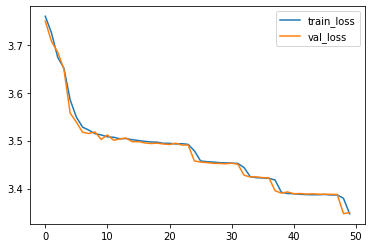

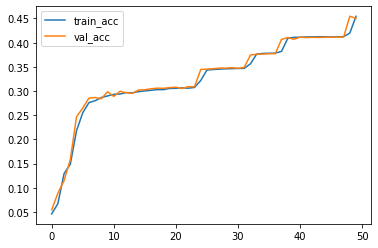

In [34]:
stats_model1[['train_loss', 'val_loss']].plot()
plt.show()
stats_model1[['train_acc', 'val_acc']].plot()
plt.show()

Second model:
Extra convolutional layer with more features

Added dropout after convolutional layers to reduce number of parameters to train and prevent possible overfitting. 

Added batch normalization after linear layer to stabilize the training


In [0]:
class ConvModel2(torch.nn.Module):
    def __init__(self):
        super(ConvModel2, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 3)
        self.conv3 = nn.Conv2d(24, 48, 3)
        self.fc1 = nn.Linear(48 * 3 * 3, 120)
        self.bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, OUTPUT_DIM)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) 
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x) 
        x = self.dropout(x) 

        x = x.view(-1, 48 * 3 * 3)

        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.softmax(x)

        return x



In [0]:
model2 = ConvModel2()
model2.to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9)

In [32]:
count_parameters(model2)

70771

In [19]:
stats_model2 = trainModel(model2, train_loader, validation_loader, criterion, optimizer, epochs)

50 epochs complete in 13m 48s
Best training loss: 3.72, accuracy: 0.78
Best validation loss: 3.63, accuracy: 0.78


,train_loss,train_acc,val_loss,val_acc
0,3.716043,0.092547,3.633186,0.167071
1,3.531890,0.272890,3.510111,0.290014
2,3.458773,0.346053,3.418353,0.375207
3,3.389620,0.421927,3.333060,0.468945
4,3.344965,0.462255,3.327172,0.470858
5,3.314382,0.492476,3.251469,0.561025
6,3.258020,0.552091,3.225012,0.576967
7,3.221748,0.586234,3.179712,0.623772
8,3.189178,0.622609,3.151192,0.651830
9,3.174322,0.633066,3.154300,0.649662


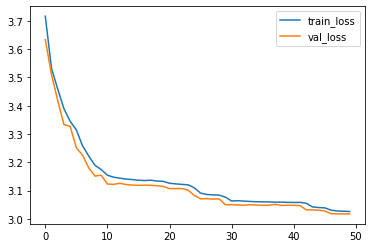

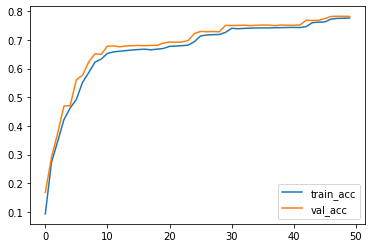

In [38]:
stats_model2[['train_loss', 'val_loss']].plot()
plt.show()
stats_model2[['train_acc', 'val_acc']].plot()
plt.show()

Another convolutional layer significantly improved performance of the model.
Number of parameters is reduced, though we use more layers now

Third model.

Added another fully connected layer with batch normalization

In [0]:
class ConvModel3(torch.nn.Module):
    def __init__(self):
        super(ConvModel3, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 3)
        self.conv3 = nn.Conv2d(24, 48, 3)
        self.fc1 = nn.Linear(48 * 3 * 3, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 48)
        self.bn2 = nn.BatchNorm1d(48)
        self.fc3 = nn.Linear(48, OUTPUT_DIM)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) 
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x) 
        x = self.dropout(x) 

        x = x.view(-1, 48 * 3 * 3)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.bn2(x)

        x = self.fc3(x)
        
        x = self.softmax(x)

        return x



In [0]:
model3 = ConvModel3()
model3.to(device)
optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate, momentum=0.9)

In [39]:
count_parameters(model3)

73579

In [22]:
stats_model3 = trainModel(model3, train_loader, validation_loader, criterion, optimizer, epochs)

50 epochs complete in 14m 3s
Best training loss: 3.64, accuracy: 0.77
Best validation loss: 3.48, accuracy: 0.77


,train_loss,train_acc,val_loss,val_acc
0,3.641721,0.176964,3.480522,0.317306
1,3.461829,0.344682,3.402951,0.405816
2,3.384085,0.426231,3.333274,0.477108
3,3.318233,0.491329,3.259096,0.548272
4,3.242081,0.572271,3.192830,0.612932
5,3.206557,0.601919,3.176174,0.630277
6,3.179045,0.630420,3.148651,0.655274
7,3.159728,0.647093,3.140099,0.662416
8,3.153838,0.651460,3.137594,0.663181
9,3.151285,0.653182,3.136284,0.664456


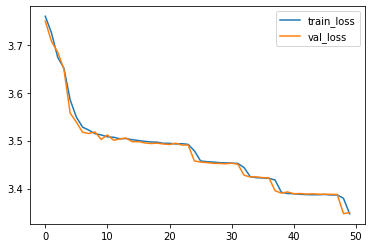

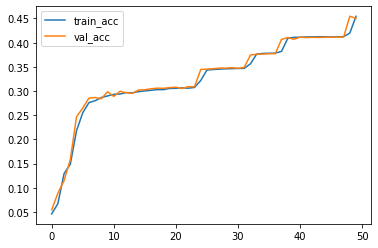

In [36]:
stats_model3[['train_loss', 'val_loss']].plot()
plt.show()
stats_model3[['train_acc', 'val_acc']].plot()
plt.show()

Stacking another linear layer  haven't really improved the model

Fourth model

Now we will try to increase the number of extracted features in the convolutional part of the model.
We increase number of dimensions for the first conv. layer and remove the polling after it.
Dropout is used after each convolution

In [0]:
class ConvModel4(torch.nn.Module):
    def __init__(self):
        super(ConvModel4, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 24, 3)
        self.conv3 = nn.Conv2d(24, 48, 3)
        self.fc1 = nn.Linear(48 * 8 * 8, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, OUTPUT_DIM)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) 
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x) 
        x = self.dropout(x) 

        x = x.view(-1, 48 * 8 * 8)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.fc2(x)        
        x = self.softmax(x)

        return x



In [0]:
model4 = ConvModel4()
model4.to(device)
optimizer = torch.optim.SGD(model4.parameters(), lr=learning_rate, momentum=0.9)

In [45]:
count_parameters(model4)

390499

In [46]:
stats_model4 = trainModel(model4, train_loader, validation_loader, criterion, optimizer, epochs)

50 epochs complete in 14m 45s
Best training loss: 3.63, accuracy: 0.97
Best validation loss: 3.48, accuracy: 0.96


,train_loss,train_acc,val_loss,val_acc
0,3.626736,0.187994,3.484992,0.335799
1,3.387689,0.426199,3.300511,0.508864
2,3.256498,0.556236,3.154371,0.656676
3,3.141428,0.674382,3.102464,0.698380
4,3.089023,0.725740,3.042159,0.765336
5,3.054946,0.754591,3.030800,0.770437
6,3.046110,0.760138,3.020376,0.790460
7,3.016845,0.790838,2.996986,0.803724
8,3.001149,0.805694,2.982774,0.817753
9,2.993234,0.810858,2.981993,0.817753


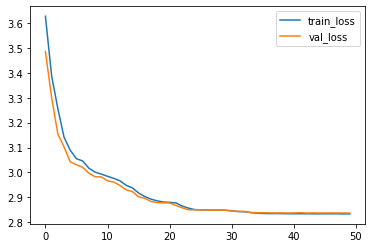

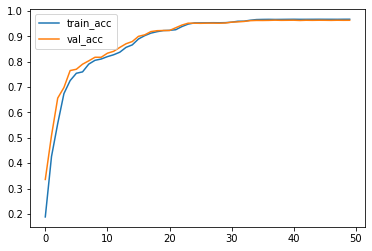

In [49]:
stats_model4[['train_loss', 'val_loss']].plot()
plt.show()
stats_model4[['train_acc', 'val_acc']].plot()
plt.show()

With increased number of features and a removed poolig layer we reached 96% of accuracy

Fifth model

We try increasing dimensions of convolution layers a bit more to check if it cann improve the accuracy.
There are 4 conv. layers in total, two dropout layers and two max poolings

In [0]:
class ConvModel5(torch.nn.Module):
    def __init__(self):
        super(ConvModel5, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 36, 3)
        self.conv3 = nn.Conv2d(36, 48, 3)
        self.conv4 = nn.Conv2d(48, 60, 3)
        self.fc1 = nn.Linear(60 * 7 * 7, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, OUTPUT_DIM)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) 

        x = self.conv3(x)
        x = self.relu(x)
        x = self.dropout(x) 

        x = self.conv4(x)
        x = self.pool(x) 
        x = self.relu(x)


        x = x.view(-1, 60 * 7 * 7)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.fc2(x)        
        x = self.softmax(x)

        return x



In [0]:
model5 = ConvModel5()
model5.to(device)
optimizer = torch.optim.SGD(model5.parameters(), lr=learning_rate, momentum=0.9)

In [70]:
count_parameters(model5)

408427

In [71]:
stats_model5 = trainModel(model5, train_loader, validation_loader, criterion, optimizer, epochs)

50 epochs complete in 14m 49s
Best training loss: 3.53, accuracy: 1.00
Best validation loss: 3.29, accuracy: 1.00


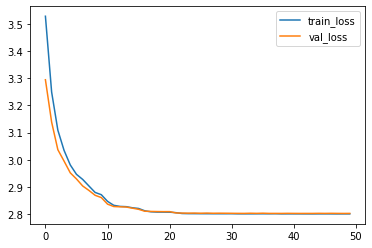

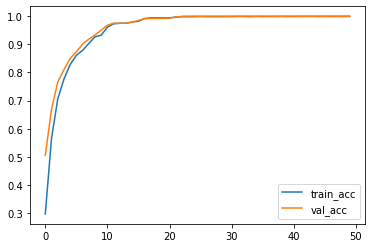

In [72]:
stats_model5[['train_loss', 'val_loss']].plot()
plt.show()
stats_model5[['train_acc', 'val_acc']].plot()
plt.show()

The final model has accuracy close to 100%.

Time to test the models on the new dataset

In [0]:
models_comparison = testModels([model1, model2, model3, model4, model5], criterion)

In [74]:
models_comparison

,0,1,2,3,4
model,"ConvModel1(\n (conv1): Conv2d(3, 12, kernel_s...","ConvModel2(\n (conv1): Conv2d(3, 12, kernel_s...","ConvModel3(\n (conv1): Conv2d(3, 12, kernel_s...","ConvModel4(\n (conv1): Conv2d(3, 24, kernel_s...","ConvModel5(\n (conv1): Conv2d(3, 24, kernel_s..."
loss,3.36777,3.02219,3.0426,2.8586,2.82732
acc,0.434046,0.781631,0.759303,0.947585,0.979652
0,0,0,0,0,1
1,0,0.997222,0.994444,0.993056,0.994444
2,0.722667,0.994667,0,0.993333,0.996
3,0,0.935556,0,0.962222,0.977778
4,0.869697,0.981818,0.963636,0.989394,0.984848
5,0.925397,0.974603,0.979365,0.992063,0.995238
6,0,0.926667,0.986667,0.86,0.906667


Only the last model is able to predict all classes allmost correctly.

Though model 4 has quite good general accuracy,, it is not able to predict 5 classes comletely.

So increasing number of features for the convolutional network was a good idea

Visualising some predictions of the final model

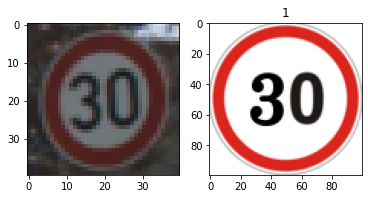

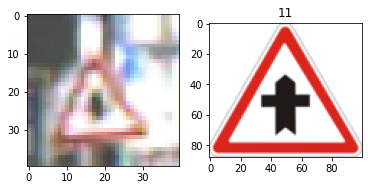

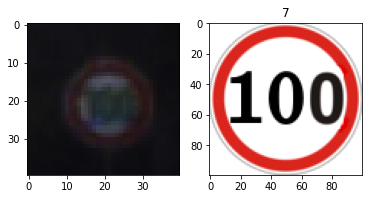

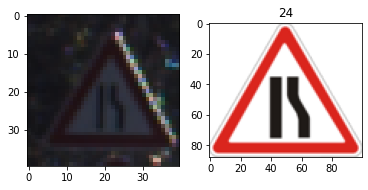

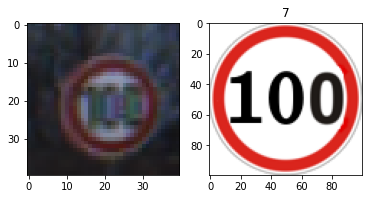

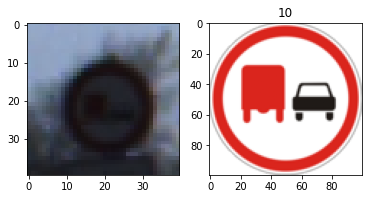

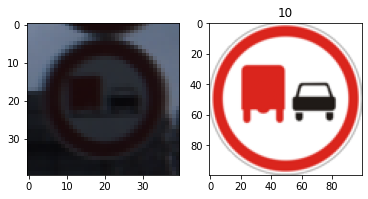

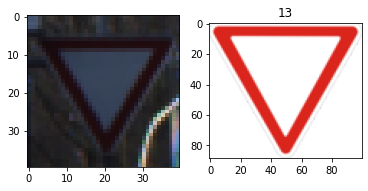

In [110]:
random_loader = torch.utils.data.DataLoader(test_data, batch_size=8,  shuffle=True)
im, lab  = next(iter(random_loader))
model5.to('cpu')
model5.eval()
with torch.set_grad_enabled(False):
  outputs = model5(im)
  _, preds = torch.max(outputs, 1)
plotImage(im, preds, test_data.classes)
